#Importación y carga de datos

##Se bajan los sets de entrenamiento y se descomprimen para su uso y posterior procesamiento.

In [ ]:
!gdown --id 1XmGfwP1z1YI5b21pIreHpsh1m1-SsCAb
!gdown --id 1F-n7ReLD0Oje_FBT3s2wlqxrKi8Qbpqg
!gdown --id 1Vpz_WawemxR-m0eau5ujK5CFItZNRp-0
!gdown --id 1Vw-wdt7dz7O3Hj23_xw3UK7IO5yRphEC
!gdown --id 10no_phQynbbbWYKmmxKd-Ll0ScQfRvaF

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XmGfwP1z1YI5b21pIreHpsh1m1-SsCAb
To: /content/train_val_masks.zip
100% 5.03M/5.03M [00:00<00:00, 41.6MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F-n7ReLD0Oje_FBT3s2wlqxrKi8Qbpqg
To: /content/train_val_images.zip
100% 183M/183M [00:02<00:00, 69.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://driv

In [ ]:
!unzip test_images.zip
!unzip train_val_images.zip
!unzip train_val_masks.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/covid1_91.png    
  inflating: images/covid2_17.png    
  inflating: images/anormal2_92.png  
  inflating: images/covid2_878.png   
  inflating: images/covid2_871.png   
  inflating: images/neum_b_340.png   
  inflating: images/neum_v_228.png   
  inflating: images/covid2_94.png    
  inflating: images/anormal2_225.png  
  inflating: images/normal_311.png   
  inflating: images/normal_940.png   
  inflating: images/neum_v_92.png    
  inflating: images/anormal2_340.png  
  inflating: images/neum_v_126.png   
  inflating: images/anormal2_400.png  
  inflating: images/normal_268.png   
  inflating: images/covid2_331.png   
  inflating: images/covid2_868.png   
  inflating: images/normal_1185.png  
  inflating: images/normal_642.png   
  inflating: images/covid2_28.png    
  inflating: images/covid2_888.png   
  inflating: images/covid2_902.png   
  inflating: images/covid2_302.png   
  inflating: images/normal_80.png 

##Importación de librerias y lectura de pickle para sets de entrenamiento y validación.

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import random
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pickle
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Dropout
from keras.layers import BatchNormalization
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cf
train_val = pickle.load(open("train_val_files.pkl",'rb'))

##Creación del dataset, agregando a una lista las imágenes (x_train) y otra lista las etiquetas correspondientes a cada imágen (y_train)

In [ ]:
def create_dataset(img_folder,pkl,dataset):
    img_data_array = [] #Lista de imagenes
    class_name = [] #lista de clases 0 (no covid) o 1 (covid)

    for file in pkl[dataset]:
        image_path = os.path.join(img_folder, file) #ruta de imagen
        image = cv2.imread(image_path) #lectura de imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #para asegurar que posean solo 1 canal
        image = np.array(image) #se transforma a un numpy array para que sirva de input para la red
        image = image.astype('float32')
        image /= 255 #estandarización de imagen
        img_data_array.append(image)
        if "covid" in file[:5]: #se añade una etiqueta 1 si es que la imagen posee el nombre covid en ella
          class_name.append(1)
        else: #si no es covid se añade una etiqueta de 0
          class_name.append(0)
    return img_data_array, class_name
x_train, y_train = create_dataset(r'images',train_val,'train') #se crea el set de entrenamiento
x_val, y_val = create_dataset(r'images',train_val,'validation') #se crea el set de validación

#EDA

##Visualización de imágen para ver si está correctamente cargada

(256, 256)


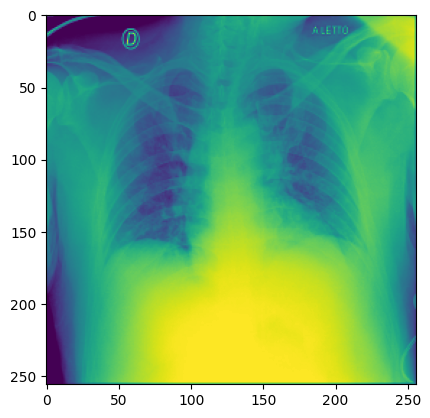

In [ ]:
print(x_train[0].shape)
plt.imshow(x_train[0])

##Visualización de la representación del set entrenamiento

896 2753


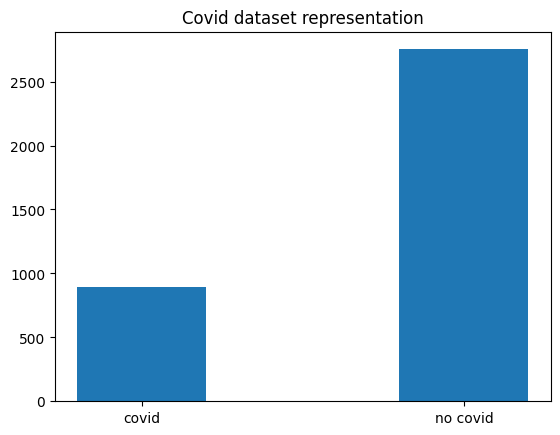

In [ ]:
x_axis = ["covid","no covid"]
y_axis = [y_train.count(1),y_train.count(0)]
print(y_axis[0],y_axis[1])
plt.bar(x_axis, y_axis, width = 0.4)
plt.title("Covid dataset representation")
plt.show()

Se puede observar que el dataset no se encuentra balanceado, por lo que se procede a balancearlo aplicando distintas transformaciones a las imagenes de Covid.

Se aplican distintas transformaciones a las imágenes que corresponden a Covid para balancear los datos.

In [ ]:
#Se voltea una imagen horizontalmente
def flip(img):
  flip = np.fliplr(np.float32(img))
  return flip

#Se rota la imágen entre -25 y 25 grados
def rotate(img,h=256,w=256):
  center = (h/2,w/2)
  angle = random.randint(-25,25)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(np.float32(img), M, (h,w))
  return rotated

#Se difumina la imágen ligeramente
def blur (img):
  x = random.randrange(1,5,2)
  blur = cv2.GaussianBlur(np.float32(img),(x,x),cv2.BORDER_DEFAULT)
  return blur

#Se translada la imagen entre -20 y 20 pixeles
def translation (image):
    x= random.randint(-20,20)
    y = random.randint(-20,20)
    rows,cols,z = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv.warpAffine(image,M,(cols,rows))

    return translate

#se elige una transformacion al azar
def transform(img):
  option = random.randint(1,3)
  if option == 1:
    img = flip(img)
  elif option == 2:
    img = rotate(img)
  elif option == 3:
    img = blur(img)
  elif option == 4:
    img = translate(img)
  return img

#funcion para generar nuevas imagenes de covid hasta lograr un balance entre
#imagenes de covid vs no covid
def data_augment(covid_samples, non_covid_samples, x_train, y_train):
  diff = len(x_train) - covid_samples #diferencia entre imagenes
  new_x_train = x_train #nueva lista en la que se añaden nuevas imagenes de covid
  new_y_train = y_train #nueva lista para añadir las etiquetas faltantes
  while covid_samples < non_covid_samples:
    for i,img in enumerate(x_train):
      if covid_samples >= non_covid_samples:
        break
      if y_train[i] != 1: #verifica que sea solo rayos-x de covid
        continue
      new_img = transform(img) #se genera una "nueva" imagen transformando la imagen actual
                               #con una transformacion definida en la funcion transform
      new_x_train.append(new_img) #se añade la nueva imagen
      new_y_train.append(1) #se añade la nueva etiqueta
      covid_samples += 1 #se aumenta el contador de imagenes con covid
  return new_x_train, new_y_train

x_train, y_train = data_augment(y_train.count(1), y_train.count(0), x_train, y_train)

Se muestra una de las nuevas imagenes generadas para ver si fue generada correctamente

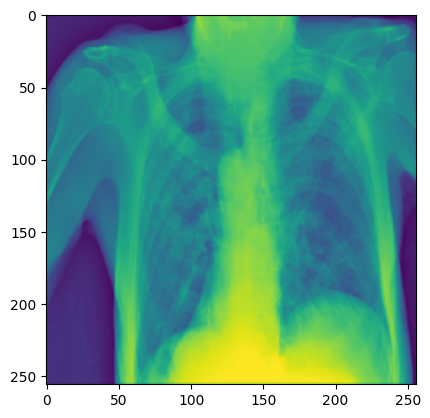

In [ ]:
plt.imshow(x_train[5000])

Se muestra la nueva representación de los datos, para ver que están balanceados correctamente

2753 2753


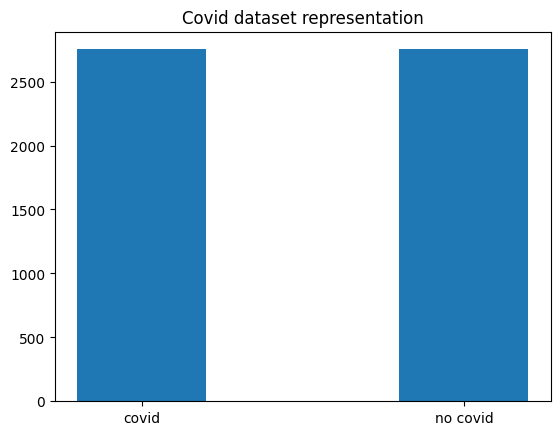

In [ ]:
x_axis = ["covid","no covid"]
y_axis = [y_train.count(1),y_train.count(0)]
print(y_axis[0],y_axis[1])
plt.bar(x_axis, y_axis, width = 0.4)
plt.title("Covid dataset representation")
plt.show()

Se aplica One Hot Encoding a las etiquetas.

In [ ]:
y_train = np.array(y_train)
print(y_train.shape)
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_val

(5506,)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#Construcción y entrenamiento del modelo

##Construcción del modelo de Red Neuronal Convolucional.

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(256,256,1)))
model.add(Dropout(0.20))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Dropout(0.20))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Dropout(0.20))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(Dropout(0.20))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.50))
model.add(Dense(2, activation="softmax"))

#funcion para ir ajustando el learning rate durante el entrenamiento
def scheduler(epoch):
    if epoch < 30:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

#callback de la funcion para ajustar el learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback para guardar los pesos de la epoch con mejor resultado de perdida en el set de validacion
checkpoint = ModelCheckpoint('covid_cnn_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')
#callback de early stopping con paciencia hasta 8 epocas
stopping = EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 dropout (Dropout)           (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
#transformacion de las listas en numpy array para que la red pueda recibirlo como input
x_train = np.array(x_train)
x_val = np.array(x_val)

In [ ]:
#se añade una dimensión ya que las imagenes tienen un shape de 256x256 y debe ser de 256x256x1 para el input de la red
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)

In [ ]:
x_train.shape

(5506, 256, 256, 1)

In [ ]:
x_val.shape

(1564, 256, 256, 1)

##Entrenamiento del modelo

In [ ]:
#entrenamiento de la red con 100 epochs y callbacks para obtener los mejores resultados posibles
history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val,y_val), callbacks = [checkpoint, stopping, lr_schedule])

Epoch 1/100
173/173 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.7824
Epoch 1: val_loss improved from inf to 0.39675, saving model to covid_cnn_weights.h5
173/173 [==============================] - 51s 218ms/step - loss: 0.4545 - accuracy: 0.7824 - val_loss: 0.3967 - val_accuracy: 0.8286 - lr: 1.0000e-04
Epoch 2/100
172/173 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8686
Epoch 2: val_loss improved from 0.39675 to 0.37513, saving model to covid_cnn_weights.h5
173/173 [==============================] - 38s 217ms/step - loss: 0.3132 - accuracy: 0.8687 - val_loss: 0.3751 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 3/100
172/173 [============================>.] - ETA: 0s - loss: 0.2732 - accuracy: 0.8830
Epoch 3: val_loss improved from 0.37513 to 0.31618, saving model to covid_cnn_weights.h5
173/173 [==============================] - 38s 218ms/step - loss: 0.2733 - accuracy: 0.8829 - val_loss: 0.3162 - val_accuracy: 0.8645 - lr: 1.00

KeyboardInterrupt: ignored

Gráfico de la pérdida del modelo durante el entrenamiento

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Gráfico de la precisión (Accuracy) del modelo durante el entrenamiento.

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#se cargan los pesos que obtuvieron menor perdida durante el entrenamiento
model.load_weights('covid_cnn_weights.h5')

In [ ]:
#prediccion de los datos de validacion
y_pred = model.predict(x_val)

In [ ]:
#transformacion de las predicciones en una lista de 0s y 1s
y_pred = [np.argmax(elem) for elem in y_pred]
y_real = [np.argmax(elem) for elem in y_val]

##Análisis del modelo

Matriz de confusión

In [ ]:
import seaborn as sn
def confusion_matrix(tp, fp, tn, fn):
  mat = [[tp, fp], [fn, tn]]
  confDf = pd.DataFrame(mat, index=["Positivo", "Negativo"], columns=["Positivo", "Negativo"])
  plt.figure(figsize = (10,7))
  sn.heatmap(confDf, annot=True, fmt="d", annot_kws={"fontsize":18}, cmap="Purples")
  plt.ylabel("Predicción", fontsize=20)
  plt.xlabel("Real", fontsize=20)
  plt.show()

c_m = cf(y_real, y_pred)
confusion_matrix(c_m[1][1], c_m[1][0], c_m[0][0], c_m[0][1])
target_names = ['No covid', 'Covid']
print(classification_report(y_real , y_pred, target_names=target_names))

Se puede observar que de los 1564 datos (set de validacion) 55 corresponden a falsos positivos (3.52%) y 36 corresponden a falsos negativos (2.3%), por lo que la red entrega resultados aceptables, ya que la cantidad de falsos negativos es baja, que es lo que se busca al diagnosticar enfermedades sobretodo en la situación actual para poder actuar correctamente y evitar posibles contagios de una mayor cantidad de falsos negativos. Esto también se ve con el f1-score el cual entrega un 0.92 como macro para este set de validación, indicando que las predicciones serán correctas un 92% de las veces

In [ ]:
print(f1_score(y_real, y_pred, average='binary'))

Lectura de imagenes de test

In [ ]:
def read_test(img_folder,pkl):
    img_data_array = []

    for files in os.walk(img_folder, topdown=False):
      for file in sorted(files[2]):
        image_path = os.path.join(img_folder, file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        img_data_array.append(image)
    return img_data_array
test_images = read_test(r'test_images',train_val)

In [ ]:
#transformacion de lista obtenida anteriormente a numpy array para pasarlo a la red
test_images = np.array(test_images)
#expansion de dimension de imagenes para pasarlas a la red
test_images = np.expand_dims(test_images, -1)

Predicción de imágenes de test para su evaluación final

In [ ]:
pred = model.predict(test_images)

In [ ]:
#carga de dataframe para evaluación final del set de test
predicted = pd.read_csv('predicted.csv')
predicted

In [ ]:
#se pasan las predicciones al dataframe
predicted['Predicted'] = [np.argmax(elem) for elem in pred]

In [ ]:
predicted.to_csv('prediccion.csv')

In [ ]:
predicted